# Análisis de vegetales

Descripciṕn de las variables del conjunto de datos:
* Contenido en ppm de diferentes elementos químicos en el suelo de una parcela: N, P, K, Ca, Mg, S, Al, Fe, Mn, Zn, Mo
* Baresoil (Categorica): Cubierta de suelo desnudo (Low, High)
* Humdepth: grosor de la capa de humus (cm).
* pH (Categorica): pH del suelo (Low, Med, High)

Objetivo principal:
* Agrupar las parcelas con aquellas con características similares (Clustering)

In [1]:
# Cargamos los datos
load("vegetal.RData")
df_vegetal <- vegetal

In [2]:
# Un vistazo a la estructura
head(df_vegetal, 2)

,N,P,K,Ca,Mg,S,Al,Fe,Mn,Zn,Mo,Baresoil,Humdepth,pH
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>
1,22.3,47.4,165.9,436.1,64.3,42.3,316.5,200.1,28.2,7.2,0.3,Low,1.5,Med
2,31.1,32.3,73.7,219.0,52.5,25.5,304.6,204.4,14.2,2.6,0.5,Low,1.8,High


---
### Análisis univariante y Multivariante

In [40]:
data.frame("Media"= sapply(df_vegetal[, 1:11], FUN=mean), 
           "Var"= sapply(df_vegetal[, 1:11], FUN=var), 
           "Min"=sapply(df_vegetal[, 1:11], FUN=min) )

,Media,Var,Min
,<dbl>,<dbl>,<dbl>
N,22.3833333,3.055971e+01,13.40
P,45.0791667,2.233948e+02,22.70
K,162.9291667,4.204532e+03,43.60
Ca,569.6625000,5.933217e+04,188.50
Mg,87.4583333,1.681930e+03,25.70
S,37.1916667,1.361382e+02,14.90
Al,142.4750000,1.496228e+04,12.10
Fe,49.6125000,3.654069e+03,2.30
Mn,49.3291667,1.149979e+03,10.10


Dato atipico en la variable Zn:

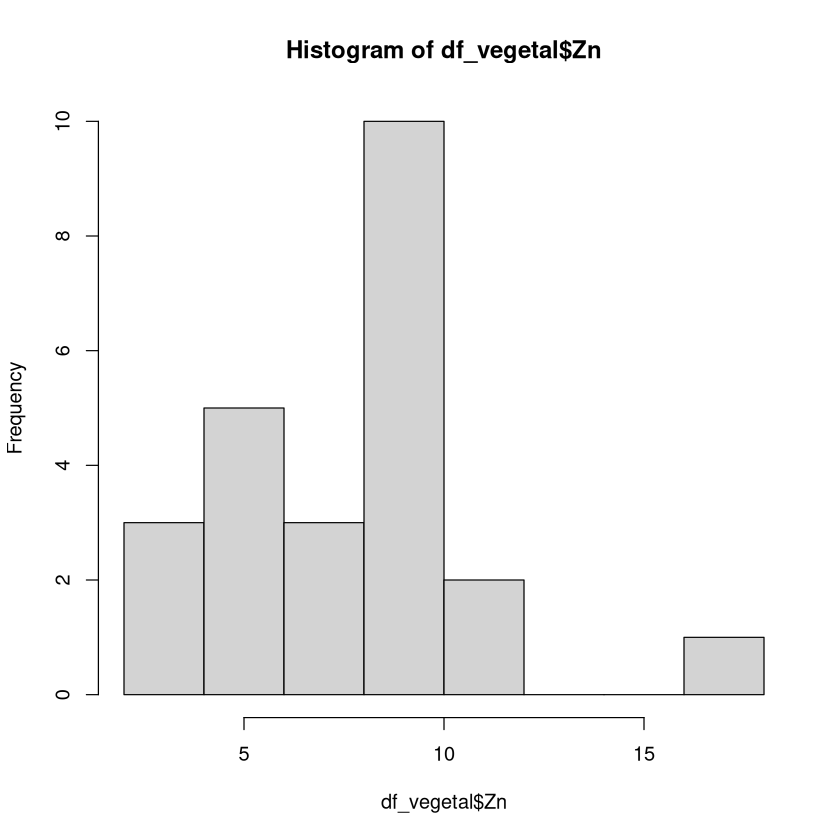

In [39]:
hist(df_vegetal$Zn, breaks = 7)

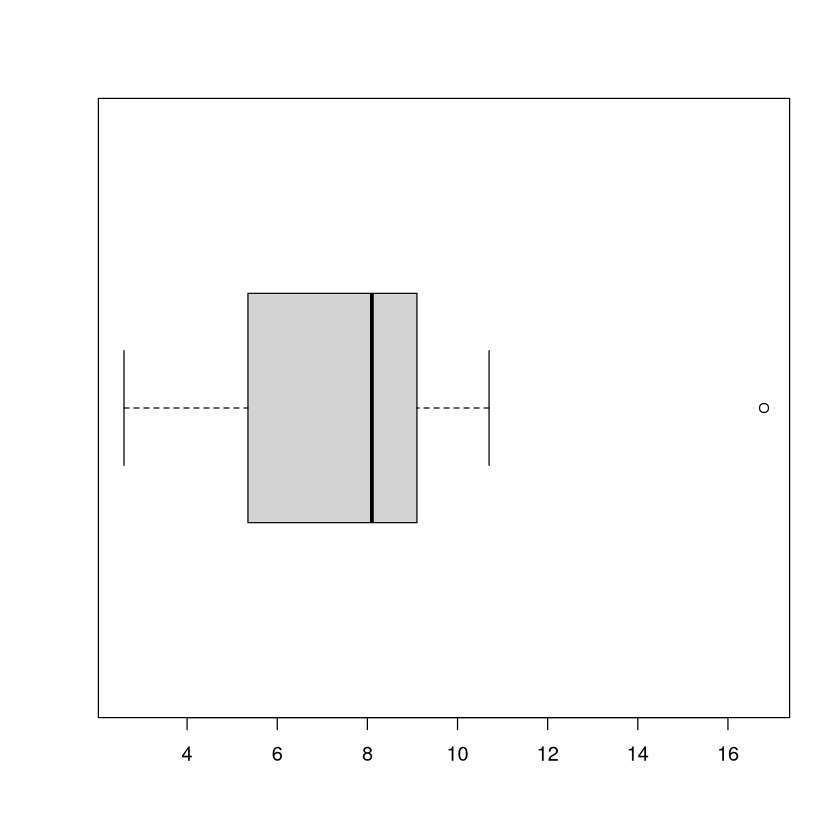

In [41]:
boxplot(df_vegetal$Zn, horizontal = T)

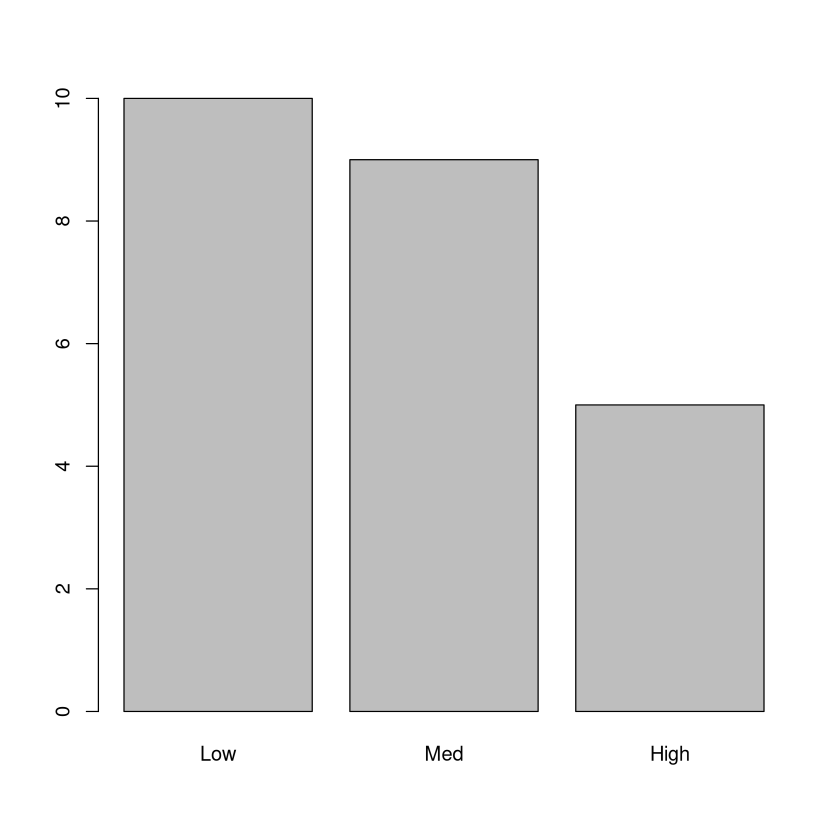

In [51]:
barplot(table(df_vegetal$pH))